## Contamination check with TPFPLOTTER

```bash
git clone https://github.com/jlillo/tpfplotter.git
```


A **contaminant** is a star, different from your target, which light is entering in your photometric aperture (i.e. the mask), causing a dilution of the transit. 

$\Delta m$ is the magnitude difference between the contaminant and your target, in the Gaia G band 

Use the TFP plot to identify possible contaminants entering in your default mask. 
- If the contaminant is within the mask, but it $\Delta m > 4$ (the contaminant is fainter than the target of 4 magnitude in G band), you can ignore it 
- if $2 < \Delta m < 4$ (with the contaminant _fainter_ than your target), but the contaminant is at leat 2 pixels away, for now you can ignore the contaminant. Later on you will need to compare the transit depth with the value in literature and with the TASTE light curve, check if they are consistent, and decide if you want to repeat the light curve extraction including the contaminant
- if $\Delta m < 2$ you should include the contaminant in the mask

To retrieve the _Gaia ID_ of the contaminat, run again tpfplotter with the additional flag `--SAVEGAIA`

```bash
  python tpfplotter.py xxxxxxxxx --maglim 6 --SAVEGAIA
```

A file with the name `Gaia_TICxxxxxxxxx_Syy.dat`, with the proper TIC number and sector of observations, will be written in the same folder of the pdf 
The file will be similar to this one:
```text

# ID GaiaID x y Dist_pix Dist_arcsec Gmag InAper
1 5284517766615492736 406.49884892803937 1809.0153210210442 0.0 0.0 12.0665 1
2 5284517762316055552 407.07494874794327 1808.5037379540615 0.7704597568443792 16.179654893731964 17.5731 1
3 5284519037925814912 406.8111820069747 1806.1456608843614 2.886607221681461 60.61875165531068 15.5482 0
```
The first row is your targetm, the other object are listed with the same ID number as in the figure. 
To find the name of the target, go to Simbad -> Query by identifier 
http://simbad.u-strasbg.fr/simbad/sim-fid
and enter in the search box:
`Gaia DR2 xxxxxxxxxxxxxxxxxxx`
where xxxxxxxxxxxxxxxxxxx is the GaiaID of the target you are interested in searching. 
You will either get the Simbad webpage of the target, or an error like the one below, with the link to the actual Gaia DR2 entry in the Vizier catalogue:
`
Identifier not found in the database : Gaia DR2 5284517762316055552
Recognized name catalogue in VizieR : Gaia DR2 5284517762316055552
`
In any case, you just need to copy the RA and DEC of the target and put them in the `Search the TESS Candidate Target List` box of ExoFOP, reachable from the main web page or directly from this link:
https://exofop.ipac.caltech.edu/tess/search.php

Now that we have the TIC number of the contaminant from the ExoFOP page, you may want to know the TESS default aperture for the contaminant and avoid the daunting task or choosing the mask by yourself. 
If you have a single sector, you can simply:
- download the TPD plot of the contaminant using tpfplotter
- update the mask of your target by adding the pixels of the contaminant 
You have multiple sectors:
- you can still use tpfplotter with the `--sector nn` flag
```bash
python tpfplotter.py xxxxxxxxx --maglim 6 --sector nn 
```
OR
- Visualize the standard pipeline mask on top of the image by running search_targetpixelfile and repeating the same steps as done for the target star 
but **remember** each sector will require a differen mask!

Let's start by importing some libraries to the environment:

- numpy to handle array functions
- astropy.io fits for accessing FITS files
- astropy.wcs WCS for World Coordinate Systems
- matplotlib.pyplot for plotting data

Note, %matplotlib inline allows us to see our plots in the notebook.

In [1]:
%matplotlib notebook 
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [2]:
# we define a common directory name
sector20_tpf = "MAST_2021-10-14T1301/TESS/tess2019357164649-s0020-0000000356473034-0165-s/tess2019357164649-s0020-0000000356473034-0165-s_tp.fits"


# Contents of Target Pixel File
Now that we have the file, we can now explore its contents. 
A FITS file is comprised of segments called Header/Data Units (HDUs), where the first HDU is called the `Primary HDU`, or `Primary Array`.
The target pixel file contains 4 extensions: a PRIMARY header, a PIXELS extension, an APERTURE extension and a TARGET COSMIC RAY extension.

- **No. 0 (Primary):**  
This HDU contains meta-data related to the entire file.
- **No. 1 (Pixels):**  
This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images.
- **No. 2 (Aperture):**  
This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing.
- **No. 3 (Target Cosmic Ray):**  
This HDU is new in the TESS target pixel files and describes the cosmic rays that were identified and subtracted from the target pixels. These cosmic ray corrections are only available if the TESS Pipeline cosmic ray correction algorithm was enabled during processing.

In [3]:
fits.info(sector20_tpf)

# With this command we copy the content of the fits file into a 
tphdu = fits.open(sector20_tpf)


Filename: MAST_2021-10-14T1301/TESS/tess2019357164649-s0020-0000000356473034-0165-s/tess2019357164649-s0020-0000000356473034-0165-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   18954R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


## Contents of the PIXELS extension.
The pixels extension contains raw and calibrated pixels collected by the spacecraft at a 2-minute cadence. Here is a sumary of the columns available in that extension.

- **TIME**: Time of mid-cadence stored in BJD-2457000.0.
- **CADENCENO**: Cadence number
- **RAW_CNTS**: The raw counts per pixel before any processing.
- **FLUX**: The calibrated, background subtracted pixels for each cadence.
- **FLUX_BKG**: The background measured and removed for these pixels.
- **QUALITY**: Quality flags.
- **POS_CORR1 & POS_CORR2**: The (column,row) local motion of the star calculated from the motion polynomials. Motion polynomials are calculated from the PSF centroids of select stars on each CCD.

In [4]:
tphdu[1].columns


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '121J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

<IPython.core.display.Javascript object>


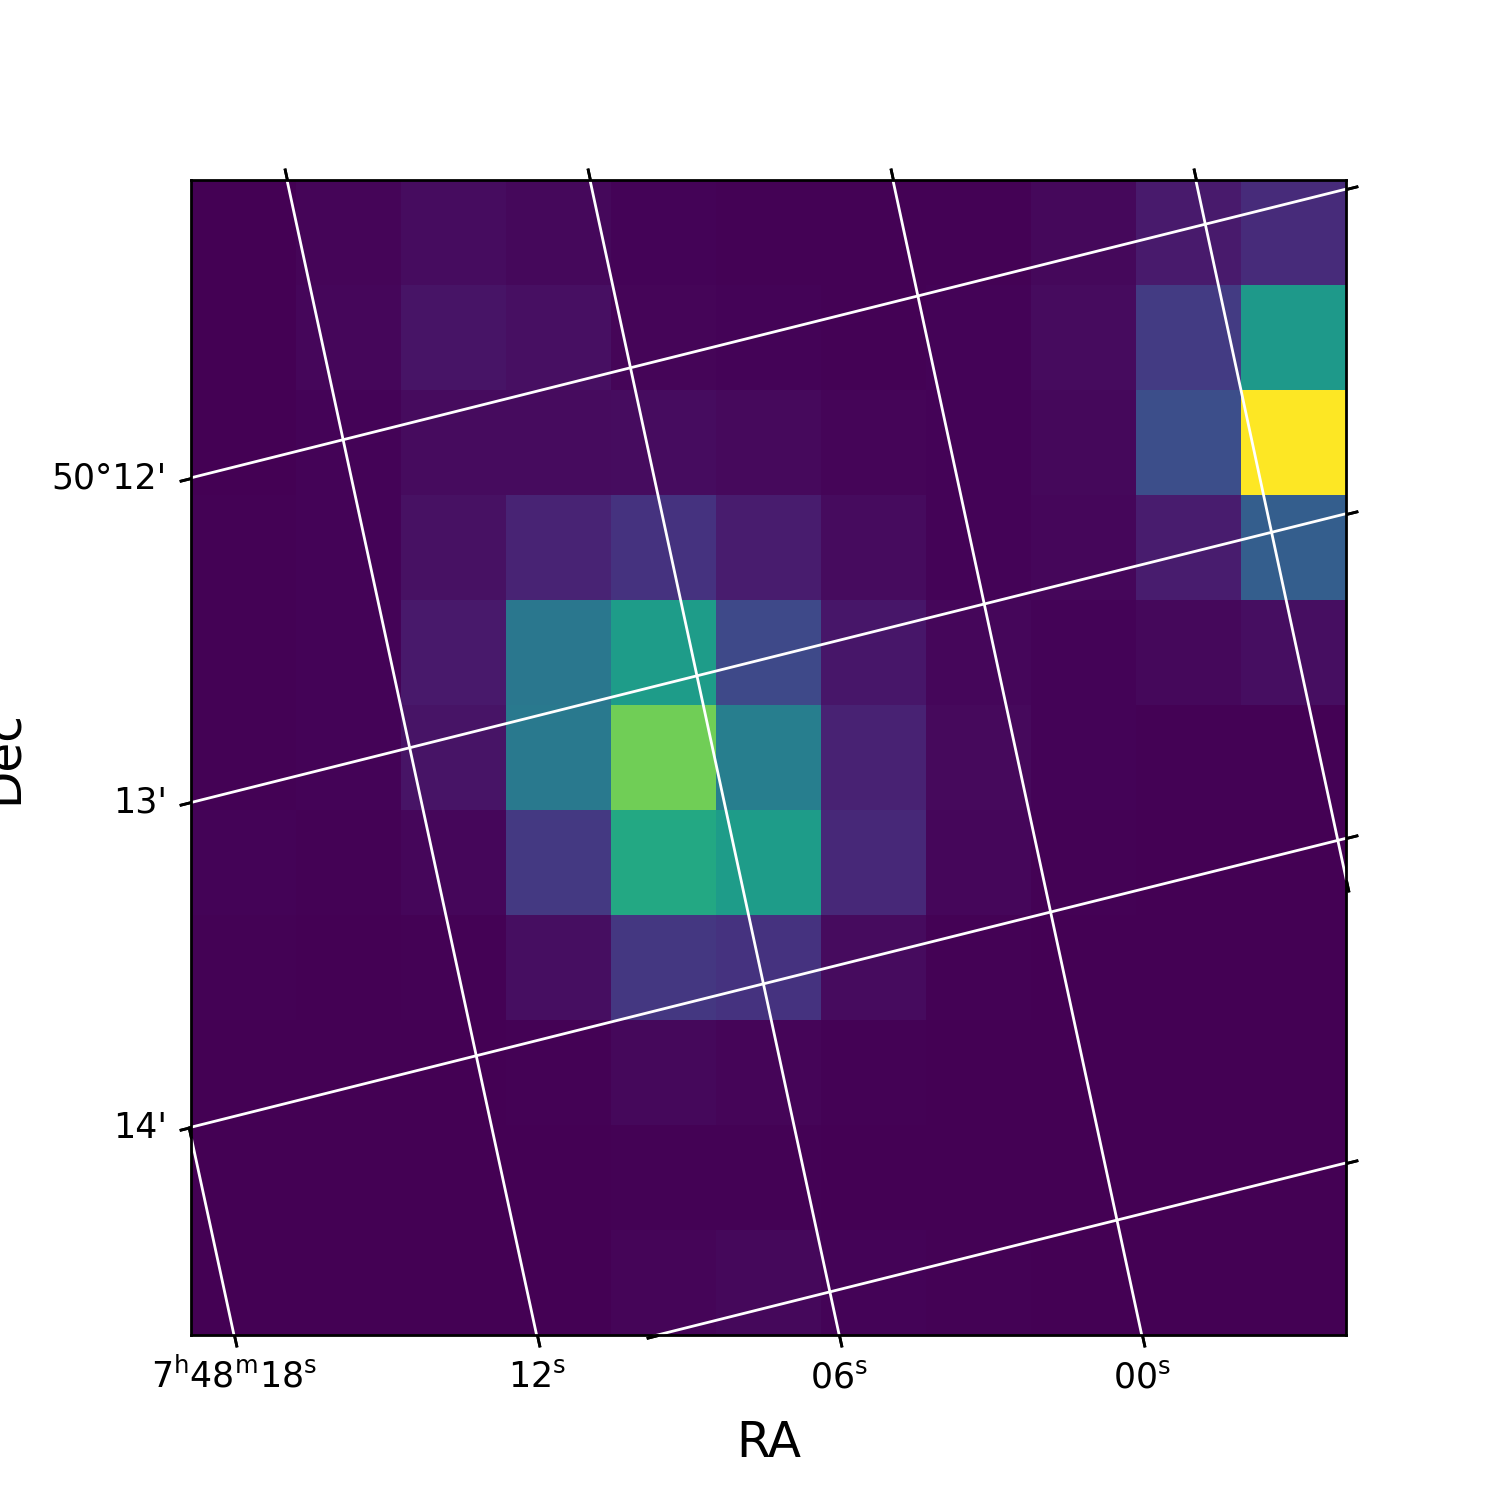

In [5]:
#Plot the first image of the FLUX Column with WCS overlay.
tpf_data = tphdu[1].data
first_image = tpf_data['FLUX'][1]

#The aperture extension header contains the same WCS as that in the Pixels extension.
wcs = WCS(tphdu[2].header)

#Plot the first image in the file.
fig = plt.figure(figsize = (6,6))
fig.add_subplot(111, projection = wcs)
plt.imshow(first_image, origin = 'lower', cmap = plt.cm.viridis)
plt.xlabel('RA', fontsize = 14)
plt.ylabel('Dec', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

## Extract the Array of Times from the FLUX Extension. 
Times in TESS are all offset by a value that is stored in the header under BJDREFI + BJDREFF. We have to consider this offset to get the Barycentric Julian Dates from the file. Have a look at the properties of the first column of this extension

In [6]:
tphdu[1].columns


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '121J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

In [7]:
time_bjd = tpf_data["TIME"]
tpf_head = tphdu[1].header
bjd_ref = tpf_head['BJDREFI'] + tpf_head['BJDREFF']
#print(tpf_head['BJDREFI'], tpf_head['BJDREFF'])
time = time_bjd + bjd_ref
print("TESS JD Offset is: %f" % bjd_ref)

TESS JD Offset is: 2457000.000000


In [8]:
time_bjd = tphdu[1].data['TIME'] + bjd_ref
raw_counts = tphdu[1].data['RAW_CNTS']
calibrated_fluxes = tphdu[1].data['FLUX']
calibrated_fluxes_err = tphdu[1].data['FLUX_ERR']


## Show the calibrated pixel values.
Let's display the calibrated fluxes for one of the cadences in our target pixel file. For now, we'll pick the fifth cadence (index number 4). You could of course decide to look at multiple cadences by looping over each index in the first dimension of the structure (e.g., loop over *calibrated_fluxes[i,:,:]*). 

<IPython.core.display.Javascript object>


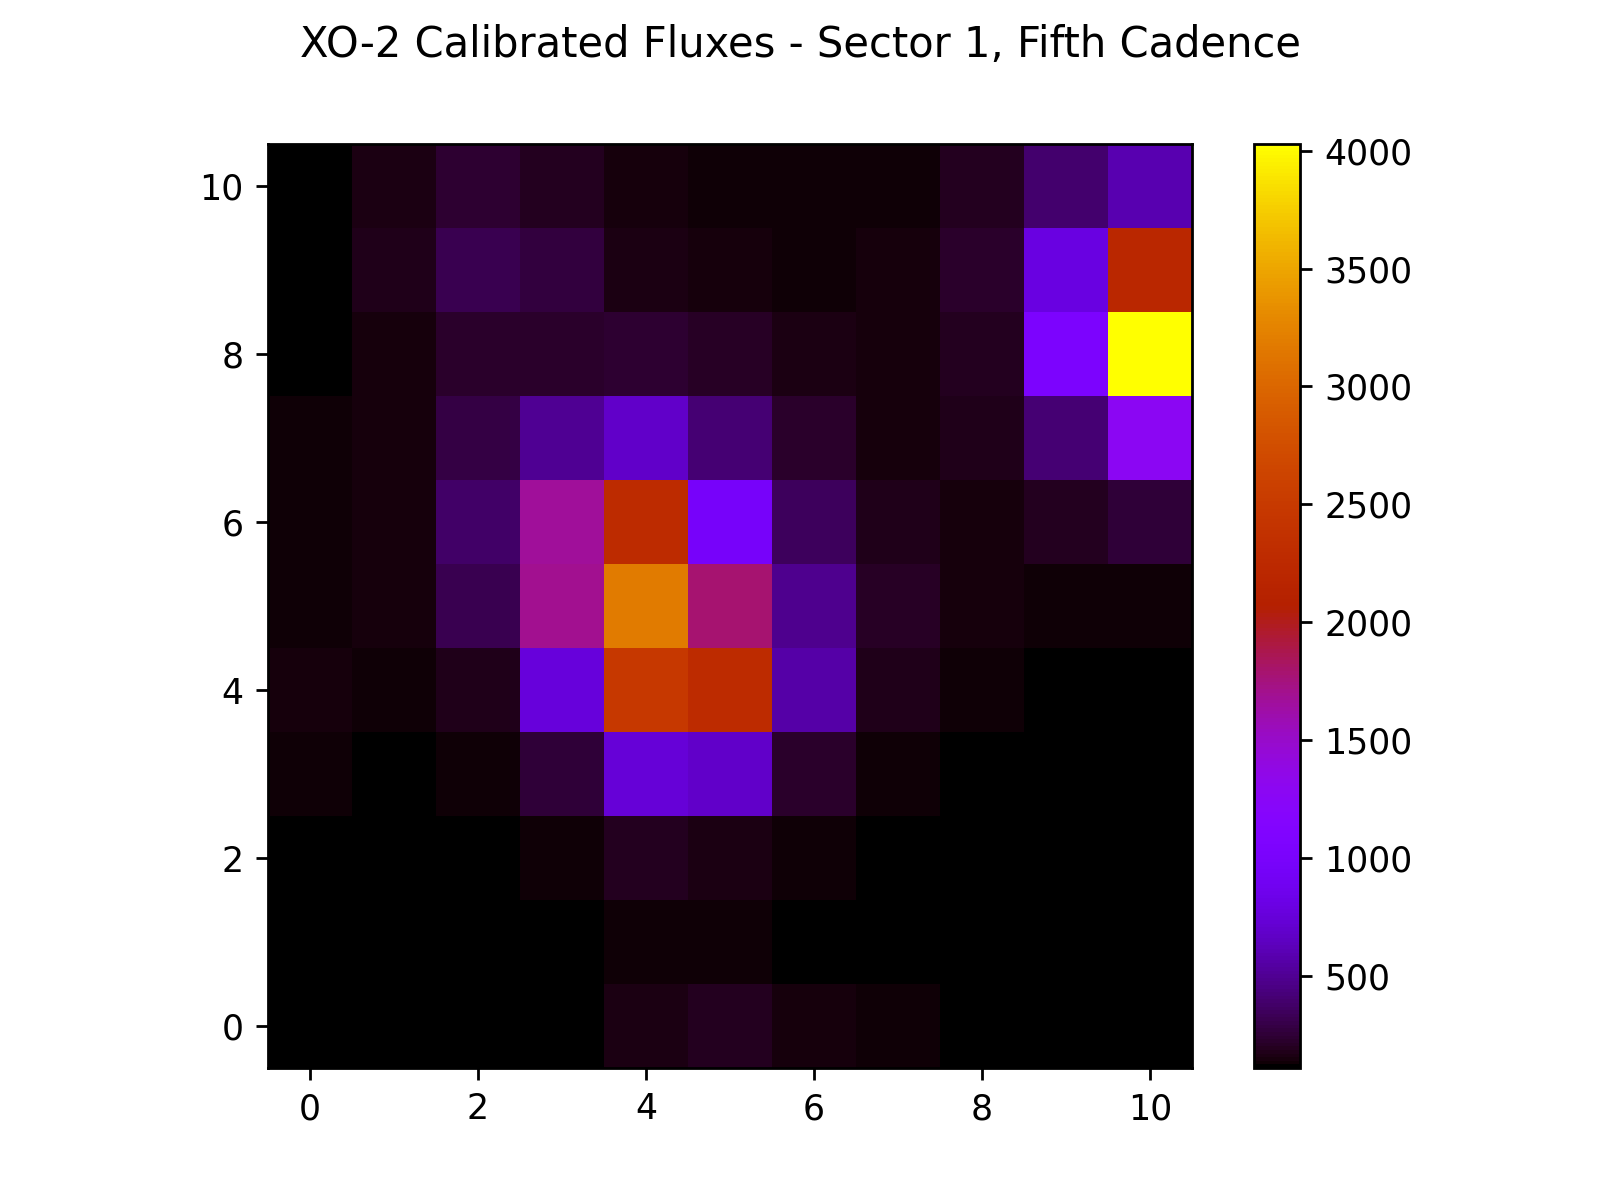

In [9]:
# Start figure and axis.
fig, ax = plt.subplots()

# Display the calibrated fluxes as an image for the fifth cadence.
cax = ax.imshow(calibrated_fluxes[1,:,:],cmap=plt.cm.gnuplot, origin="lower")
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

# Let's define a title for the figure.
fig.suptitle("XO-2 Calibrated Fluxes - Sector 1, Fifth Cadence")

# Add a color bar.
cbar = fig.colorbar(cax)
plt.show()

You could even make an animated .gif of the fluxes and see how they change from cadence to cadence. To get you started though, let's just display one of the cadence's flux values.

<IPython.core.display.Javascript object>


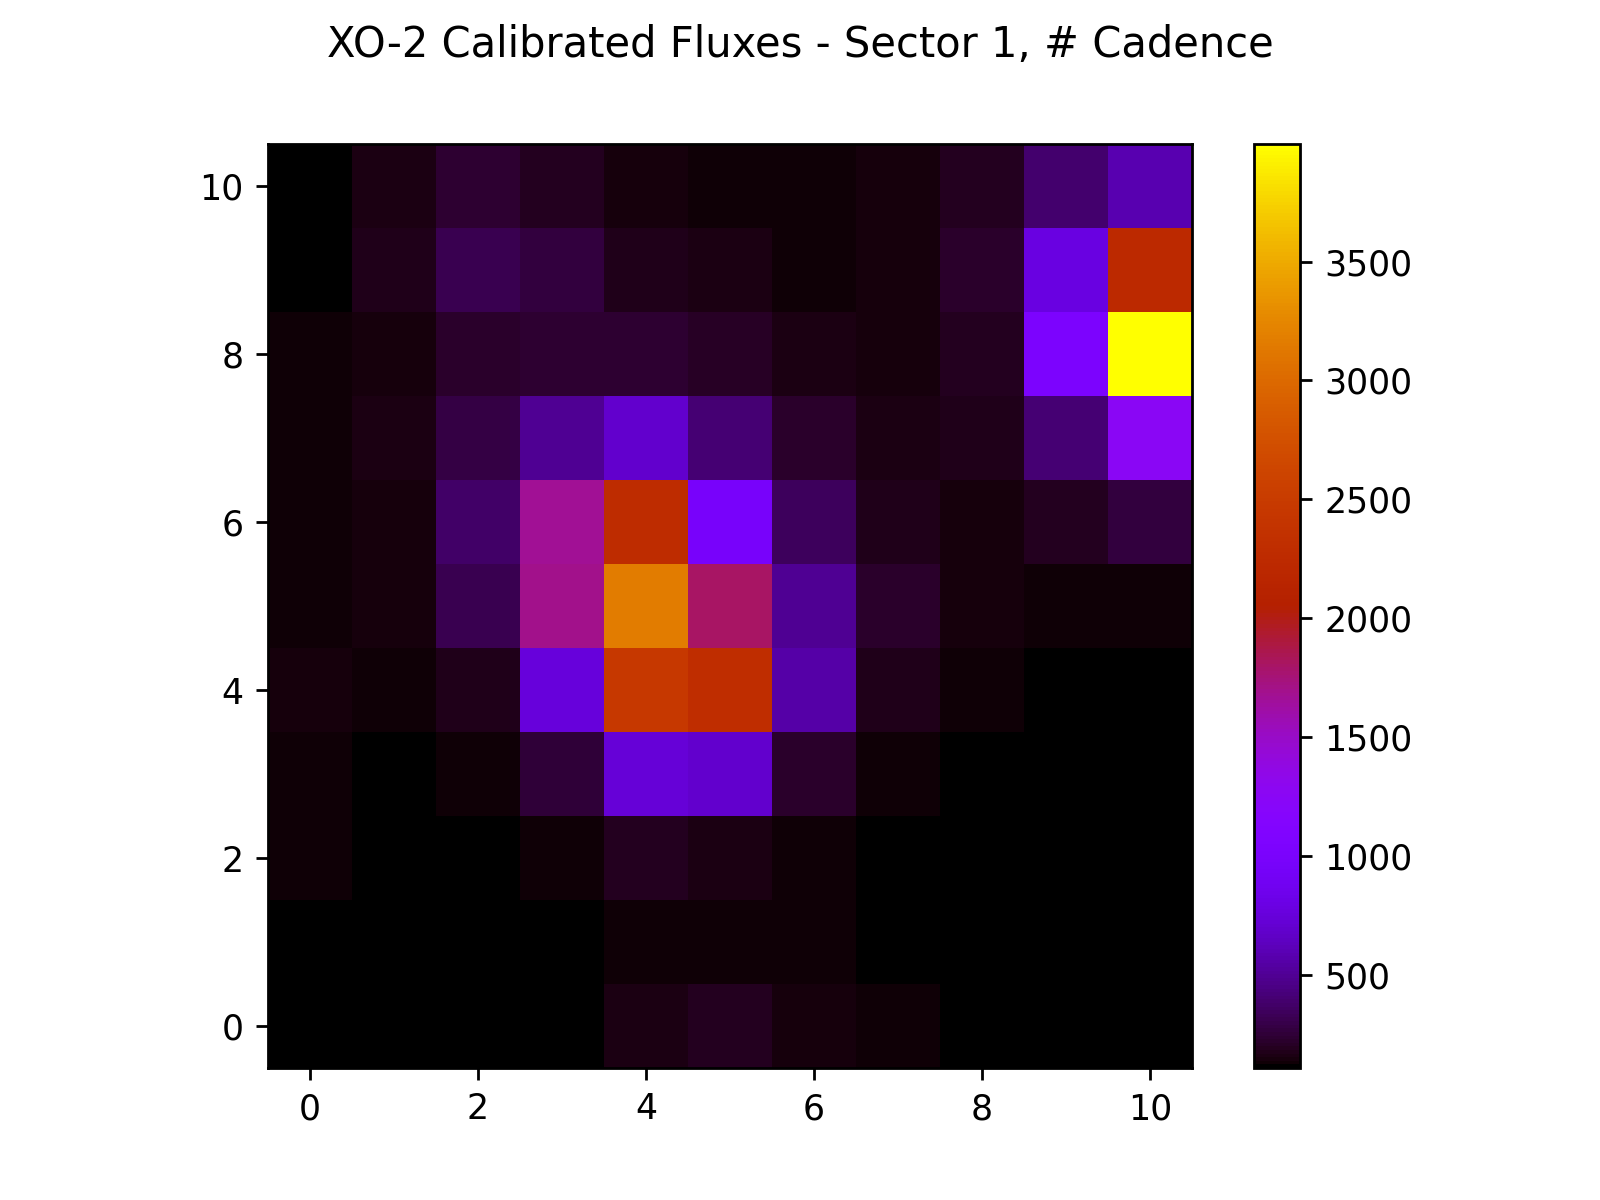

In [10]:
from matplotlib import animation


# Start figure and axis.
fig, ax = plt.subplots()


# Display the calibrated fluxes as an image for the fifth cadence.
cax = ax.imshow(calibrated_fluxes[1,:,:], cmap=plt.cm.gnuplot, origin="lower")
#ax.imshow(aperture, cmap=plt.cm.YlGnBu_r, origin="lower", alpha=0.50)

# Let's define a title for the figure.
fig.suptitle("XO-2 Calibrated Fluxes - Sector 1, # Cadence")


cax =   ax.imshow(calibrated_fluxes[0,:,:], cmap=plt.cm.gnuplot, origin="lower")
# Add a color bar.
cbar = fig.colorbar(cax)

def update_linechart(i):
    cax.set_array(calibrated_fluxes[i,:,:])

    

num_frames = len(calibrated_fluxes[:,0,0])
anim = animation.FuncAnimation(fig, update_linechart, frames = num_frames)
plt.show()
#anim.save('xo2_gif.gif', fps = 20)


In [11]:
plt.close()

# Displaying The Aperture Pixel Information
Let's read in the second FITS extension HDU to display the aperture information. First, let's read in the aperture pixels from the HDU.



In [12]:
ap_image = (tphdu[2].data)
print(ap_image)
#ap_want = np.bitwise_and(ap_image, 2) / float(2)
#print(ap_want)

[[257 261 261 261 257 257 257 257 257 257 257]
 [257 261 261 261 257 257 257 261 261 261 257]
 [257 257 261 257 257 257 257 257 261 261 257]
 [257 257 257 257 267 267 267 257 261 261 257]
 [261 261 257 267 267 267 267 257 261 261 257]
 [261 261 257 257 257 267 267 257 261 261 257]
 [261 261 257 257 257 257 257 257 261 257 257]
 [261 261 257 257 257 257 257 261 257 257 257]
 [257 257 257 257 257 257 261 261 257 257 257]
 [257 257 257 257 257 257 257 257 257 257 257]
 [257 257 257 257 257 257 257 257 257 257 257]]


## Understanding The Aperture Pixel Values
We see the pixel values are integers, but what do they mean? The pixels are bitmasks that encode information about each pixel. For example, a pixel in the aperture that might have a value of 57 can be broken down into power of 2 like: 32+16+8+1 = 57. Referencing the table of values, this means this particular pixel was in CCD Output A, was used to calculate the PRF centroid, was used to calculate the flux weighted centroid, and was collected by the spacecraft. Numpy has a bulit-in function that can convert an integer into a binary bit mask. Let's use that now one one of the common values we see in our displayed image above.

In [13]:
# Break down a pixel value of 267 (yellow pixels displayed above) into its constituent bits.
bits = np.binary_repr(267)
print(bits)

bits = np.binary_repr(257)
print(bits)


100001011
100000001


## Overplot the pixel aperture on top of the image

<IPython.core.display.Javascript object>


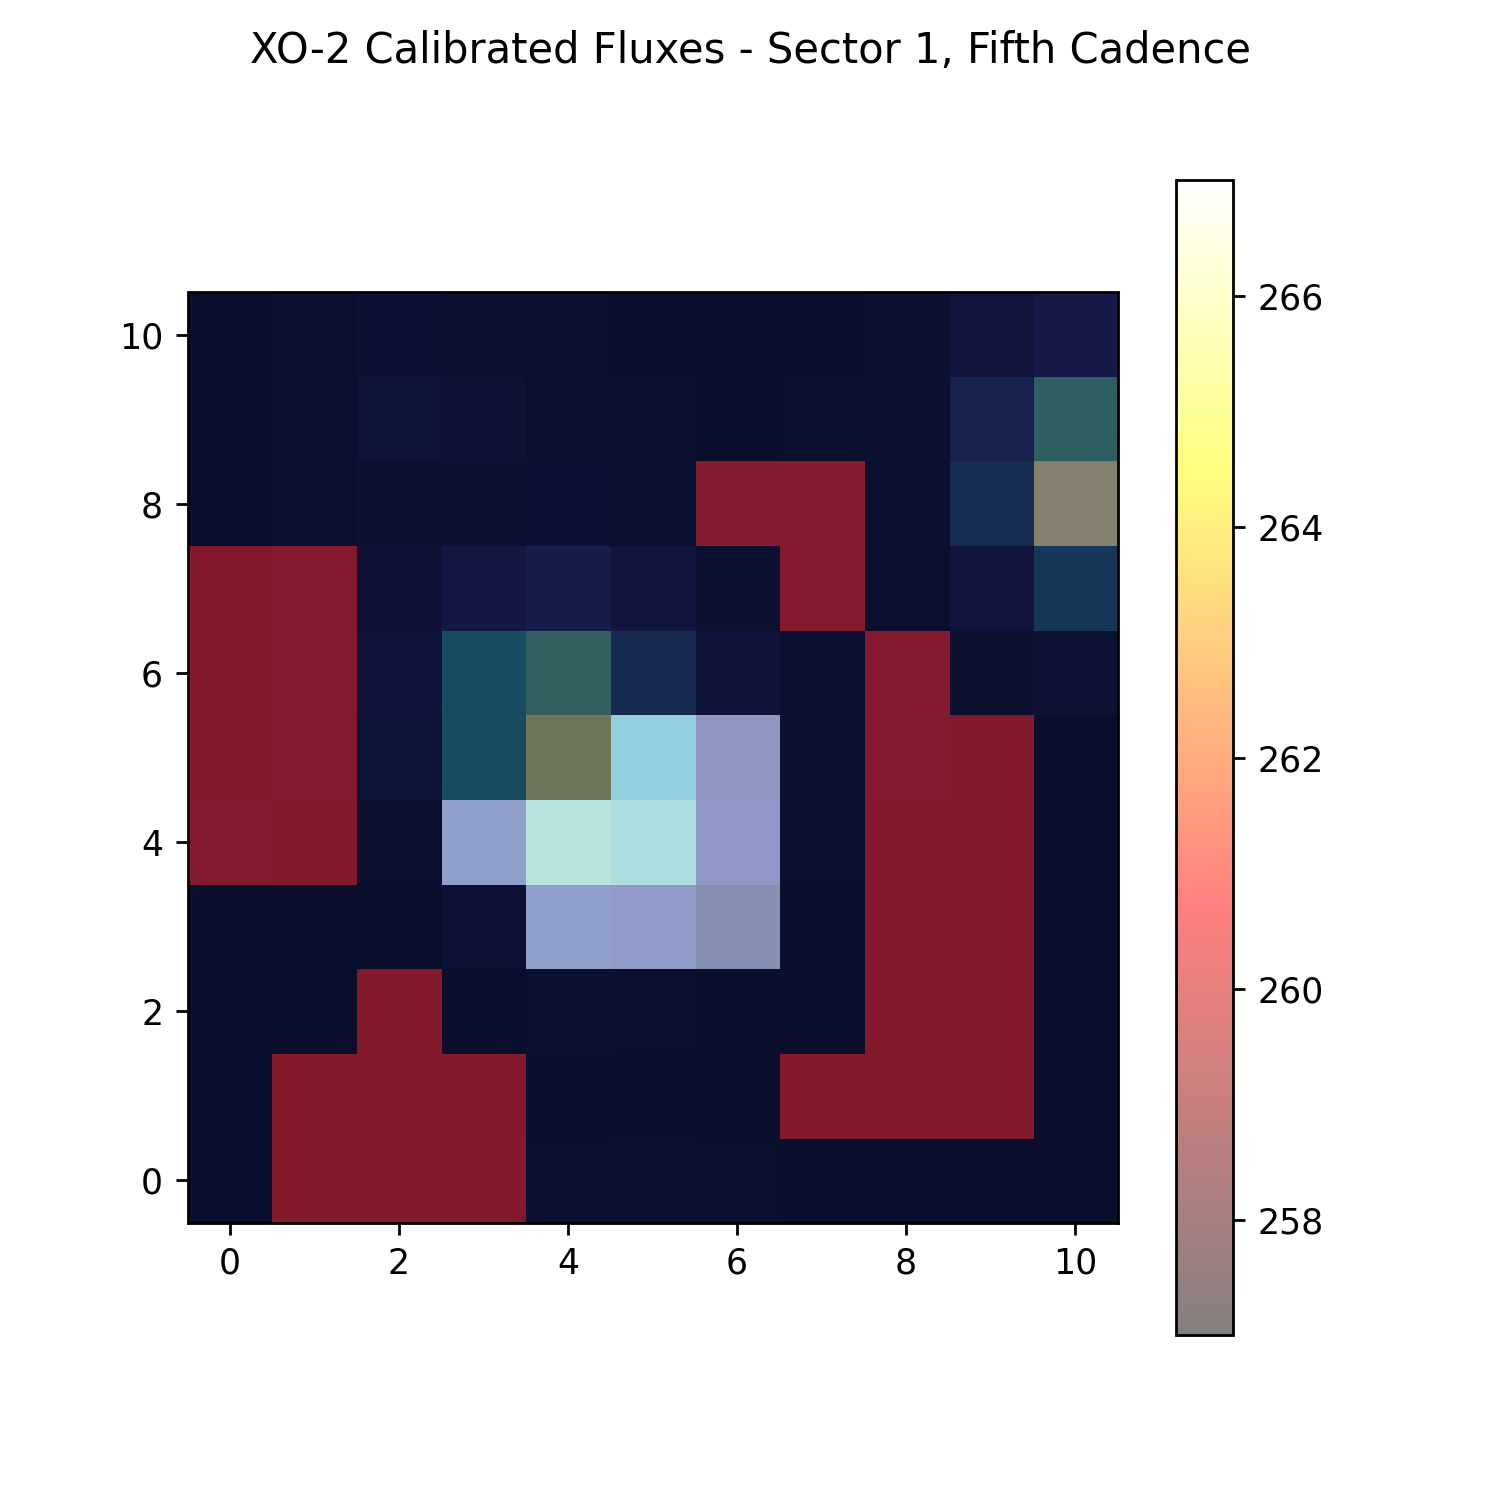

In [14]:
plt.close()
aperture = tphdu[2].data

# Start figure and axis.
fig, ax = plt.subplots(figsize=(6,6))

# Display the calibrated fluxes as an image for the fifth cadence.
cax = ax.imshow(calibrated_fluxes[1,:,:], cmap=plt.cm.YlGnBu_r, origin="lower")
cbx = ax.imshow(aperture, cmap=plt.cm.hot, origin="lower", alpha=0.5)

# Let's define a title for the figure.
fig.suptitle("XO-2 Calibrated Fluxes - Sector 1, Fifth Cadence")

# Add a color bar.
cbar = fig.colorbar(cbx)
plt.show()

# Performing aperture photometry 

## Step 1. Read in the Aperture information from the third extension. 
Each pixel in the aperture extension image is an integer that represents a set of binary flags. The entire set of flags and what they mean can be found in the TESS Archive Manual. Of interest to us in this exersize is which pixels belong to the "optimal aperture" used to create this target's light curve. This is the second bit of this set of binary flags. To determine which pixels are in the optimal aperture we need to do a bitwise AND between the pixel value and the value 2. (Similarly, if you wanted to determine which pixels were used to calculate the flux-weighted centroid, you would use the 4th bit which has a value of 2^(4-1)=8.)


The number 13 is represented by 00001101.\
Likewise,  17 is represented by 00010001.\
The bit-wise AND of 13 and 17 is therefore 000000001, or 1.

In [15]:

ap_want = np.bitwise_and(ap_image, 2) / float(2)
print(ap_want)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Step 2. Create time series photometry using these pixels
For each cadence we will sum the values in the FLUX column associated with those pixels that show a '1' above.



In [16]:
#define a simple aperture function to sum-up specified pixels for one cadence
def aperture_phot(flux,flux_error,aperture):
    
    aperture_flux = np.sum(flux[aperture == 1])
    aperture_flux_err =  np.sqrt(np.sum(flux_error[aperture == 1]**2))
    return aperture_flux, aperture_flux_err

In [17]:
#retrieve the number of exposures (or cadence)

print(np.shape(calibrated_fluxes))
n_cadence = np.shape(calibrated_fluxes)[0]

# Simple iteration over the number of cadences
optimal_aperture_flux = np.zeros(n_cadence)
optimal_aperture_flux_err = np.zeros(n_cadence)

for ii in range(0, n_cadence):
    optimal_aperture_flux[ii], optimal_aperture_flux_err[ii] = aperture_phot(calibrated_fluxes[ii,:,:], calibrated_fluxes_err[ii,:,:], ap_want)


(18954, 11, 11)


In [18]:
#EXTRA: Use the map lambda functions to apply that function to all cadences
# the function as defined does not wirk right now

#opap_flux = np.array(list (map (lambda x: aperture_phot(x,ap_want), tpf_data['FLUX'] ) ) )
#print(opap_flux[1:10])

<IPython.core.display.Javascript object>


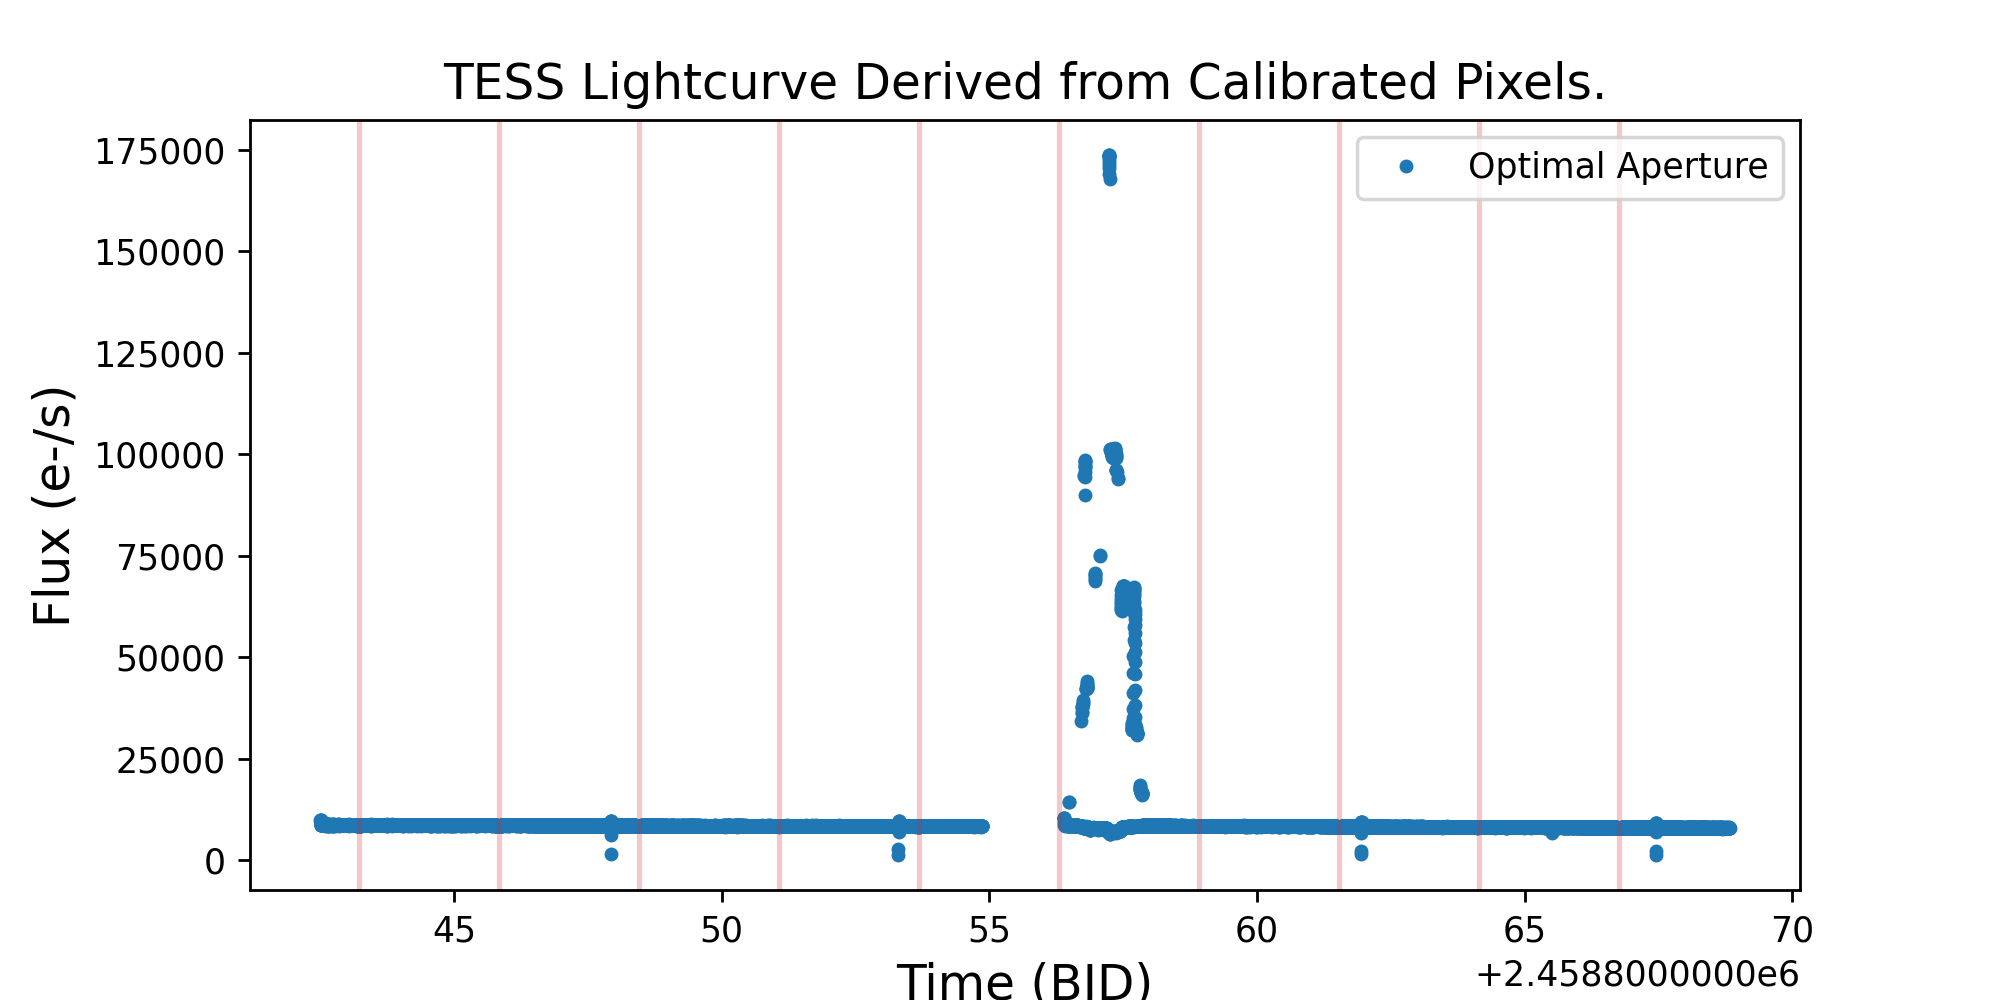

In [19]:
plt.figure(figsize = (8,4))
plt.plot(time_bjd, optimal_aperture_flux,'.', label = 'Optimal Aperture', ms = 6)

for ii in range(0,10):
    plt.axvline(2458843.218679 + 2.61582557385023*ii, c='C3', alpha=0.25)

plt.legend()
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)
plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)
plt.show()

# Create a light curve of the background flux that was subtracted.
This is very similar to the steps above, except that we want to apply the aperture to the background flux estimated for this part of the sky. This information is stored as images in the FLUX_BKG extension. Note that this background has already been subtracted from the flux values provided in the FLUX column.

## Step 1. Determine the flux from the background in the optimal aperture.
This is done using that same aperture_phot function we wrote above. And we are using the same optimal aperture we defined above.



In [20]:
background_fluxes = tpf_data['FLUX_BKG']
background_fluxes_err = tpf_data['FLUX_BKG_ERR']

# Simple iteration over the number of cadences
background_aperture_flux = np.zeros(n_cadence)
background_aperture_flux_err = np.zeros(n_cadence)
for ii in range(0, n_cadence):
    background_aperture_flux[ii], background_aperture_flux_err[ii] = aperture_phot(background_fluxes[ii,:,:], background_fluxes_err[ii,:,:], ap_want)


## Step 2. Plot this background flux against the time.



<IPython.core.display.Javascript object>


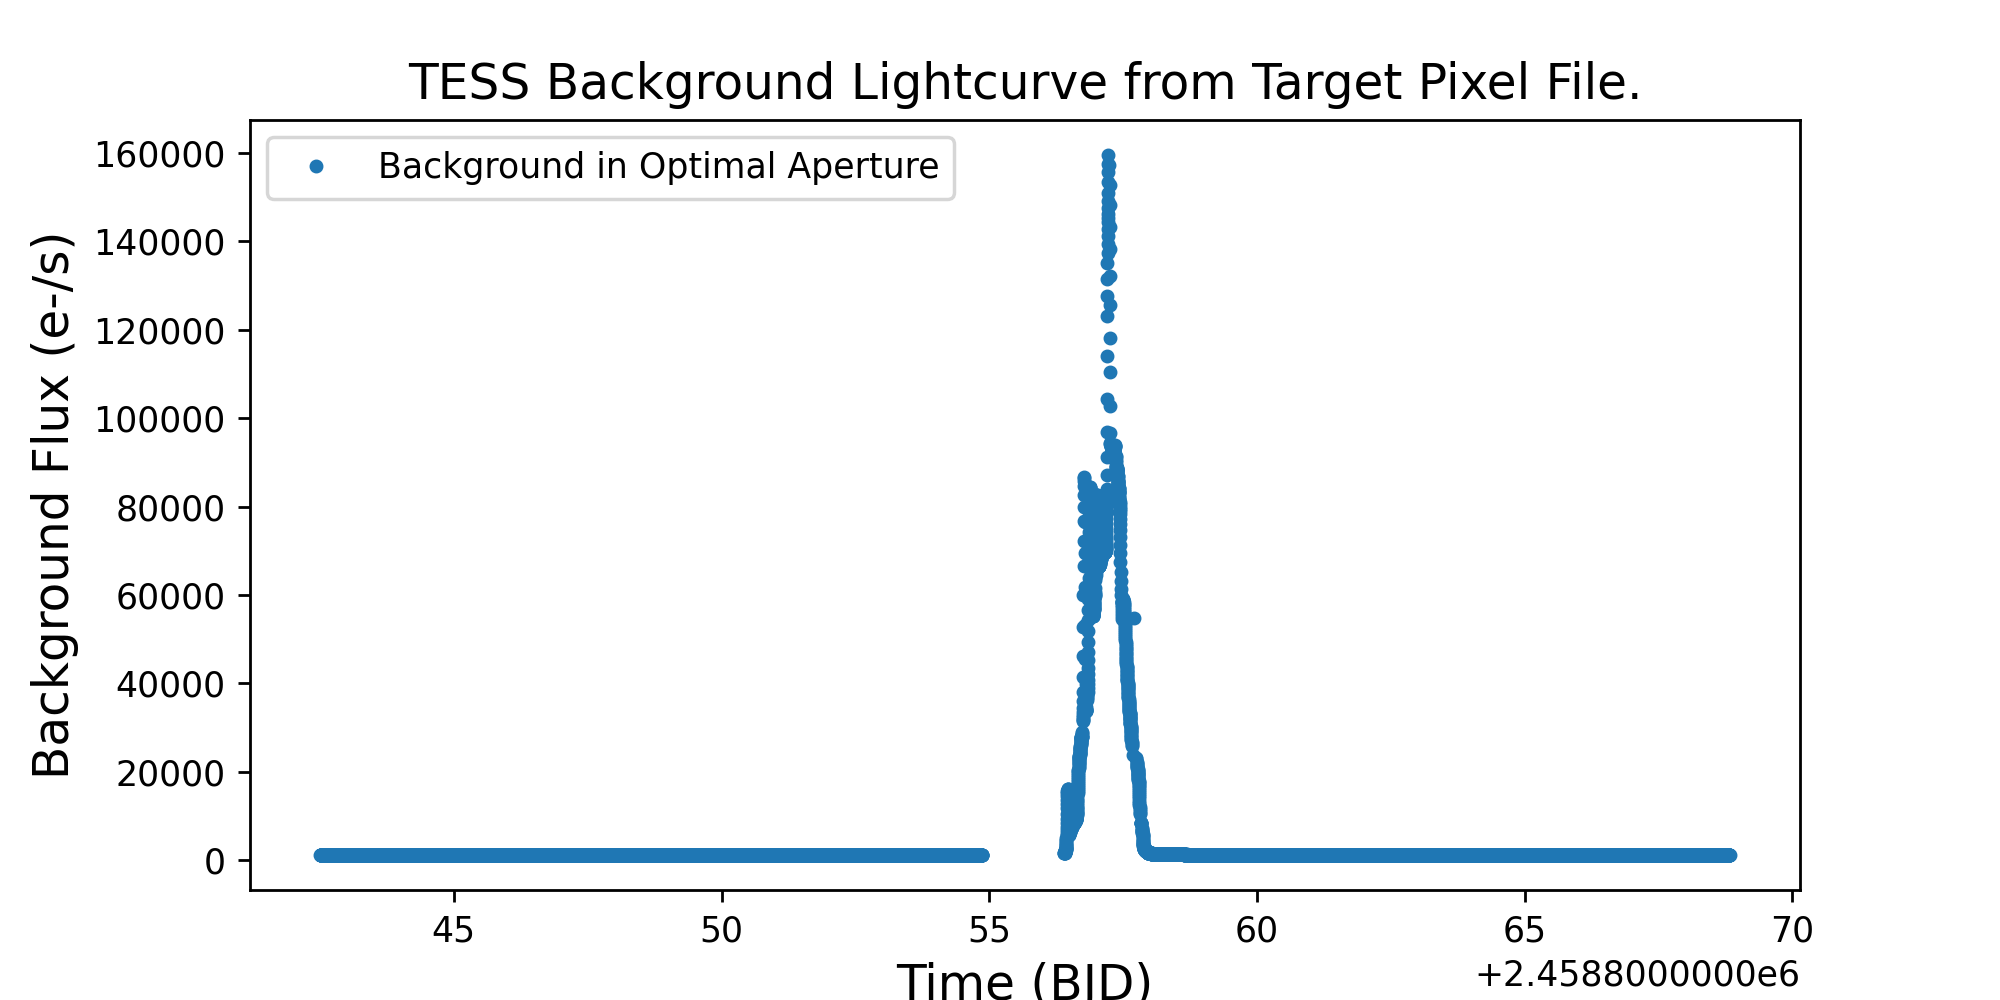

Text(0.5, 1.0, 'TESS Background Lightcurve from Target Pixel File.')

In [21]:
plt.figure(figsize = (8,4))
plt.plot(time_bjd,background_aperture_flux,'.', label = 'Background in Optimal Aperture', ms=6)
plt.legend()
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Background Flux (e-/s)', fontsize = 14)
plt.title("TESS Background Lightcurve from Target Pixel File.", fontsize = 14)

# Remove cadences flagged as anomalous.

The Quality column contains integers that act as binary flags identified in the TESS data. We are going to remove the data that has been flagged by one of the following flags:

Bit 1. Attitude Tweak \
Bit 2. Safe Mode \
Bit 3. Coarse Point \
Bit 4. Earth Point \
Bit 5. Argabrightening Event (Sudden brightening across the CCD.) \
Bit 6. Reaction Wheel Desaturation \
Bit 8. Manual Exclude \
Bit 10. Impulsive outlier \
Bit 12. Straylight detected \
Bit 13. Scattered Light Exclude (pipeline >= spoc-4.0.5)

The other flags are informational and do not necessarily indicate that the cadence should not be used. However, you may have scientifically valid reasons for removing those cadences as well, so it is worth learning about them. See the archive manual for a full listing of the flags.


https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview

In [22]:
quality = tpf_data['QUALITY']


In [23]:
bits_to_be_checked = np.array([1,2,3,4,5,6,8,10,12,13])
value = 0
for v in bits_to_be_checked:
    value = value + 2**(v-1)

print(value)
print(quality[3])
print()
print('{0:16d}'.format(int(np.binary_repr(value))))
print('{0:16d}'.format(int(np.binary_repr(quality[3]))))


bad_data = np.bitwise_and(quality, value) >= 1 
# those are the points to be removed

print(bad_data[3])

good_data = ~bad_data


6847
32

   1101010111111
          100000
True


<IPython.core.display.Javascript object>


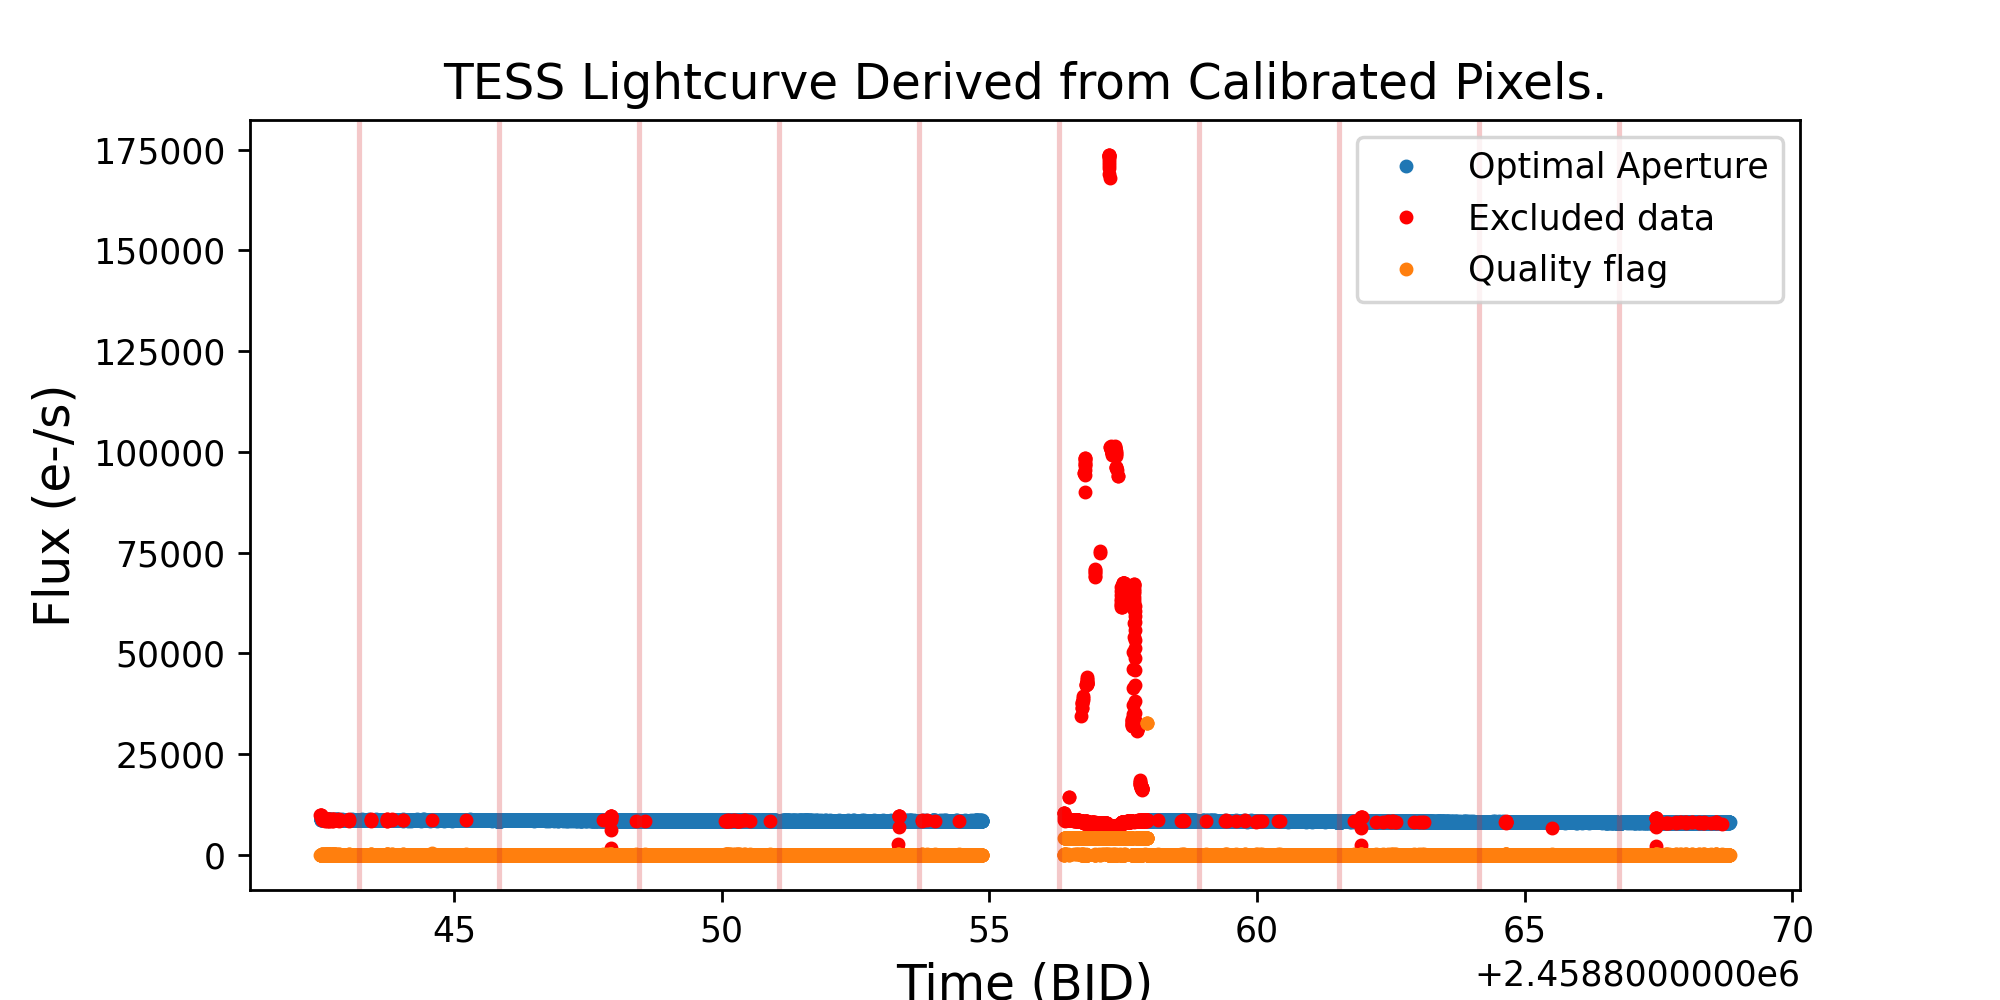

In [24]:
plt.figure(figsize = (8,4))
plt.plot(time_bjd[good_data], optimal_aperture_flux[good_data],'.', label = 'Optimal Aperture', ms = 6)
plt.plot(time_bjd[bad_data], optimal_aperture_flux[bad_data],'.', label = 'Excluded data', ms = 6, c='r')
plt.plot(time_bjd, quality,'.', label = 'Quality flag', ms = 6)



for ii in range(0,10):
    plt.axvline(2458843.218679 + 2.61582557385023*ii, c='C3', alpha=0.25)


plt.legend()
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)
plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)
plt.show()

In [25]:
# save to file

fileout = open('XO2N_optimal_aperture.dat', 'w')

for b,v,e in zip(time_bjd[good_data], 
                 optimal_aperture_flux[good_data], 
                 optimal_aperture_flux_err[good_data]):
    fileout.write('{0:16f} {1:16f} {2:16f}\n'.format(b,v,e))
fileout.close()